<a href="https://colab.research.google.com/github/DeltSystem32/CIS3187-Assignment/blob/master/Copy_of_CIS3187_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Intelligence Coursework: Neural Network
## By Daniel Anthony Cilia 315499(M)
---



## Project Imports



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Prepare Data
 Read and parse data

Obtain testing and traning data from two CSV files in the project repository on Github.

The data consists of 5-bit numbers being mapped to 3-bit via the Boolean function ¬ABC.

Converters are used to map values to string upon import in order to retain all leading zeros.

#### Training set:

In [443]:
data_url = "https://raw.githubusercontent.com/DeltSystem32/CIS3187-Assignment/master/full_dataset.csv?token=AIW66N4UA46SZD3JMZIWU7C6ERXXE"
df = pd.read_csv(data_url, converters={'input': lambda x: str(x), 'output': lambda x: str(x)})
df

,Num,input,output
0,1,00000,100
1,2,00001,100
2,3,00010,100
3,4,00011,100
4,5,00100,101
5,6,00101,101
6,7,00110,101
7,8,00111,101
8,9,01000,110
9,10,01001,110


#### Shuffle DataFrame rows

In [444]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Num,input,output
0,28,11011,010
1,7,00110,101
2,8,00111,101
3,25,11000,010
4,16,01111,111
5,4,00011,100
6,11,01010,110
7,23,10110,001
8,26,11001,010
9,27,11010,010


#### Separate into trianing and testing datasets:

In [445]:
training_df = df[:26]
training_df

,Num,input,output
0,28,11011,010
1,7,00110,101
2,8,00111,101
3,25,11000,010
4,16,01111,111
5,4,00011,100
6,11,01010,110
7,23,10110,001
8,26,11001,010
9,27,11010,010


#### Testing set:

In [446]:
testing_df = df[26:]
testing_df

,Num,input,output
26,12,01011,110
27,5,00100,101
28,18,10001,000
29,30,11101,011
30,10,01001,110
31,31,11110,011


#### Size of data:

In [447]:
print("Size of training set: " + str(len(training_df)))
print("Size of testing set: "+ str(len(testing_df)))

Size of training set: 26
Size of testing set: 6


## MLP Parameters

The Neural Network to be implemented will consist of the following:
*   **Number of input neurons**: 5
*   **Number of output neurons**: 3
*   **Number of hidden layers**: 1
*   **Number of hidden neurons**: 4
*   **Error threshold**: 0.2
*   **Learning rate**: 0.2
*   **Maximum number of epochs**: 999
*   **Transformation function**: Sigmoid

In [0]:
class parameters:
  NUM_IN_NEURONS = 5
  NUM_OUT_NEURONS = 3
  NUM_HIDDEN_LAYERS = 1
  NUM_HIDDEN_NEURONS = 4
  ERROR_THRESHOLD = 0.25
  LEARNING_RATE = 0.2
  MAX_EPOCHS = 999

### Sigmoid function implementation

The method will be called *transform()* so as to remain generic so that its body can be 'hotswapped' with other transformation functions if the need arises.

In [0]:
def transform(x):
  #sigmoid
  return 1 / (1 + np.exp(-x))
    

#add to MLP parameters
parameters.transform = transform

## MLP Class

### Initialisation

We will first begin by declaring the MLP's initialisation function. An array of 5-bit binary numbers is to be received:

In [0]:
class MLP:
  output = None
    
  def __init__(self):
    global wH, wO
    #hidden layer weights
    wH = self.generate_weights(parameters.NUM_IN_NEURONS,parameters.NUM_HIDDEN_NEURONS)
    #output layer weights
    wO = self.generate_weights(parameters.NUM_HIDDEN_NEURONS,parameters.NUM_OUT_NEURONS)

    print("Weights randomly generated.")
    print("Hidden weights:\n", wH)
    print("Output weights:\n", wO)

  def train(self, input_df):
    global wH, wO, epochs_list
    epoch = 1
    epochs_list = []

    print("------------------------------------------")

    while epoch <= parameters.MAX_EPOCHS:
      is_converged = True
      num_bad_facts = 0
      print("Epoch ", epoch)
      
      for index, fact in input_df.iterrows():
        input = np.array(list(fact["input"]),dtype=np.float64)
        target_output = np.array(list(fact["output"]),dtype=np.float64)
        # print("Input: ", input)
        # print("Expected Output: ", target_output)
        

        # print(wH)
        # print(wO)
        result = self.feedforward(input, target_output)
        output, outH = result[0], result[1]

        error = self.calculate_error(target_output, output)
        is_good_fact = self.check_fact(error)

        print(output)
        if not is_good_fact:
          num_bad_facts += 1
          print("False")
          is_converged = False
          self.error_backpropagation(output, outH, target_output, input)

        else:
          print("True")
      if is_converged:
        print("Converged!!!!!!!!!!!!")
        break
      else:
        epochs_list.append([epoch, ((num_bad_facts / len(input_df)) * 100)])
        epoch += 1
        print("------------------------------------------")
  
  def plot(self):
    self.plot_epoch_graph(epochs_list)
        

To initialise the weights, we will need to do so randomly from -1 to 1. For this, a function is required to create a matrix of weights of any given size:

In [0]:
def generate_weights(self, columns, rows):
  return np.random.uniform(low=-1,high=1, size=(columns,rows))

#add to MLP
MLP.generate_weights = generate_weights

### Feed-forward

Function for applying the transformation function to all cells of a given array:

In [0]:
def transform_array(self, net):
  return [parameters.transform(j) for j in net]

# add to MLP
MLP.transform_array = transform_array

Loop through hidden layer and output layer, transforming input into MLP output. Matrix multiplication is performed using numpy's dot function:

In [0]:

def feedforward(self, input, target):
  netH = np.dot(input,wH).astype(np.float64)
  outH = self.transform_array(netH)

  netO = np.dot(outH,wO).astype(np.float64)
  outO = self.transform_array(netO)

  return outO, outH

MLP.feedforward = feedforward

### Fact Checking

For each output of the MLP, compare with the expected output and produce the error difference: 

In [0]:
def calculate_error(self, target_output, output):
  error = np.absolute(target_output - output)

  return error

MLP.calculate_error = calculate_error

Given an array of errors, compare to error threshold and determine whether fact is good or bad:

In [0]:
def check_fact(self, error):
  error_threshold = parameters.ERROR_THRESHOLD

  for i in range(len(error)):
    if error[i] > error_threshold: 
      return False #bad fact

  return True #good fact

MLP.check_fact = check_fact

### Error Backpropagation

Revise the weights of the MLP, beginning from the output layer. 

In [0]:
def error_backpropagation(self, outOArray, outHArray, target, initialInput):
  #output layer
  deltaOut = deltaOMethod(outOArray, target)
  newWeightOutput(deltaOut, outHArray)

  #hidden layer
  deltaHidden = deltaHMethod(deltaOut, outHArray)
  newWeightHidden(deltaHidden, initialInput)

MLP.error_backpropagation = error_backpropagation

Calculate the delta of each weight and total the weight difference. Return the new output weights and the delta values generated in the process.

In [0]:
def deltaOMethod(outOArray, target): 
  i = 0 
  deltaOArray = np.array([0, 0, 0], dtype=np.float64)
  for entry in outOArray: 
    deltaOArray[i] = entry * (1 - entry) * (target[i] - entry) 
    i = i + 1 
  return deltaOArray

def newWeightOutput(deltaList, outHArray): 
  learningRate = parameters.LEARNING_RATE  
  i = 0 
  for output in outHArray: 
    x = 0 
    for delta in deltaList: 
      wO[i][x] += learningRate * delta * output 
      x = x + 1 
    i = i + 1

MLP.deltaOMethod = deltaOMethod
MLP.newWeightOutput = newWeightOutput

Do the same for the weights of the hidden layer. This follows a more complicated process.

In [0]:
def deltaHMethod(deltaOArray, outHArray): 
  i = 0 
  deltaHArray = np.array([0, 0, 0, 0], dtype=np.float64) 
  for entry in outHArray: 
    deltaHArray[i] = (entry * (1 - entry) * (sigmaDeltaO(deltaOArray, i))) 
    i = i + 1
    return deltaHArray

def sigmaDeltaO(deltaOArray, index): 
  sum = 0 
  x = 0 
  for delta in deltaOArray: 
    sum = sum + (delta * wO[index, x]) 
    x = x + 1 

  return sum

def newWeightHidden(deltaList, initialInput): 
  learningRate = parameters.LEARNING_RATE
  i = 0 
  for input in initialInput: 
    x = 0 
    for delta in deltaList: 
      wH[i][x] += learningRate * delta * input 
      x = x + 1 
    i = i + 1

MLP.deltaHMethod = deltaHMethod
MLP.sigmaDeltaO = sigmaDeltaO
MLP.newWeightHidden = newWeightHidden

## Graph Plotting

In [0]:
def plot_epoch_graph(self, epoch_list):
  epochs = np.array(epoch_list)

  for e in epoch_list:
    np.append(epochs, e)
  
  plt.plot(epochs[:,0], epochs[:,1])
  plt.xlabel('Epochs')
  plt.ylabel('% of Bad Facts')

  plt.title("Training Set")
  plt.show()

MLP.plot_epoch_graph = plot_epoch_graph

## Test Runner

In [460]:
mlp = MLP()

Weights randomly generated.
Hidden weights:
 [[-0.8125949   0.86570556  0.95577334  0.48229748]
 [ 0.17558565  0.23038878 -0.64604859  0.3731753 ]
 [-0.92400208 -0.39114338 -0.17062639 -0.25115742]
 [-0.54579015 -0.40291881  0.80518381 -0.8110567 ]
 [-0.87496325  0.27695382 -0.23187532 -0.43721494]]
Output weights:
 [[ 0.52379013  0.64860342 -0.42837712]
 [-0.62408361  0.1851972  -0.25563437]
 [ 0.96785023 -0.37268659 -0.55222539]
 [ 0.07809948  0.33356578 -0.06188981]]


In [461]:
mlp.train(training_df)

------------------------------------------
Epoch  1
[0.5800459764246247, 0.5196265934206662, 0.3430997741315986]
False
[0.6302584400123215, 0.5101536627843654, 0.36607698698538826]
False
[0.597410236851885, 0.49182622995213626, 0.384544802527572]
False
[0.5794726475951162, 0.5919321171255223, 0.337692298627833]
False
[0.5511574914865801, 0.5179509214740281, 0.39997889705037654]
False
[0.6056687889801616, 0.5176446841902715, 0.36704848847267413]
False
[0.6166356442848567, 0.5709143794798471, 0.3536059273815062]
False
[0.638633133412315, 0.49709931723862705, 0.34282938361789483]
False
[0.529970071694415, 0.5695964224652162, 0.35922894132762473]
False
[0.6030900687873598, 0.5483995417148914, 0.33033365242163004]
False
[0.5766639514831412, 0.548705290440404, 0.3447802908581319]
False
[0.4889269450196251, 0.5672311019217693, 0.4101860571903155]
False
[0.5947823257599784, 0.6073150901978348, 0.3519504611407718]
False
[0.6389020880617937, 0.5395801239648212, 0.3469077873469866]
False
[0.56527

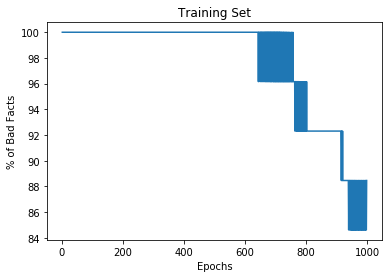

In [462]:
mlp.plot()